### DONE
- FT-HMC implemented for 8x8 2D QED (using SiLU as activation function).

- Try to minimize size of the force in training. No significant improvements.

- Some test on ergodicity

- (calculate the probablity of generating the configs obtained via conventional HMC).

### TODO

- Plot the force size distribution
- Is the large force from the original action or Field-Transformation the determinant?
- If from the determinant, then the fermion force won't cause problem for HMC

- Use the same Field-Transformation for larger system (say 16x16, 32x32, 64x64, etc)
- Study how the delta H depends on the system size ( perhaps delta H ~ sqrt(volume) )

- Study the auto-correlation for observables, topo, plaq, flowed plaq, etc.

- Improving the Field-Transformation to reduce force.

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import math
import sys
import os
from timeit import default_timer as timer
from functools import reduce

In [4]:
from rich.theme import Theme
from rich.console import Console

console = Console(record=False, width=256, log_time_format='[%X] ', theme=Theme({
    'repr.number': 'bold bright_green',
    'repr.attrib_name': 'bold bright_magenta',
}))

def put(s):
    console.log(s)

In [5]:
project_dir = os.path.abspath('../../')
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
    
from utils.param import Param

In [6]:
def print_metrics(history, avg_last_n_epochs=10, era=None, epoch=None):
    outstr = []
    
    if era is not None:
        outstr.append(f'era: {era}')
    if epoch is not None:
        outstr.append(f'epoch: {epoch}')
        
    #if era is not None and epoch is not None:
    #    console.rule(f'ERA: {era} | EPOCH: {epoch} metrics', style='yellow')
        
    for key, val in history.items():
        val = np.array(val)
        if len(val.shape) > 0:
            avgd = np.mean(val[-avg_last_n_epochs:])
        else:
            avgd = np.mean(val)
        outstr.append(f'{key}: {avgd:g}')
        
    outstr = ', '.join(outstr)
    console.log(outstr)
    
    return outstr

In [7]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 1, # 0.3
    nstep = 8, # 3
    nrun = 8,
    # ADJUST ME
    ntraj = 128, # 2**16 # 2**10 # 2**15
    nprint = 10,
    seed = 1331
)

put(param.summary())

In [8]:
torch.manual_seed(param.seed)

torch.set_num_threads(param.nth)
torch.set_num_interop_threads(param.nth_interop)
os.environ["OMP_NUM_THREADS"] = str(param.nth)
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

torch.set_default_tensor_type(torch.DoubleTensor)

In [34]:
import utils.qed_helpers as qed
import ipynb.field_transformation as ft

def run(param, field = None, keep_fields=False):
    if field is None:
        field = param.initializer()
        
    fields = {i: [] for i in range(param.nrun)}
    
    with open(param.uniquestr(), "w") as O:
        params = param.summary()
        O.write(params)
        put(params)
        plaq = qed.action(param, field)
        topo = qed.topo_charge(field[None, :])
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        O.write(status)
        put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                dH, exp_mdH, acc, field = qed.hmc(param, field, verbose=False)
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                topo = qed.topo_charge(field[None, :])
                topo1 = qed.topo_charge1(field[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                status = {
                    'traj': f'{n * param.ntraj+i+1:4}',
                    'accept': f'{acc}',
                    'dH': f'{dH:< 12.8}',
                    'expdH': f'{exp_mdH:< 12.8}',
                    'plaq': f'{plaq:< 12.8}',
                    'topo': f'{qed.grab(topo)[0]:< 3.3}',
                }
                outstr = ', '.join(
                    '='.join((k, v)) for k, v in status.items()
                )
                O.write(outstr + '\n')
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    put(outstr)
                    
                if keep_fields:
                    fields[n].append(field)
                else:
                    fields[n] = field
                    
            t += timer()
            ts.append(t)
        put(f'Run times: {ts}')
        put(f'Per trajectory: {[t / param.ntraj for t in ts]}')
        
    
    return fields

In [10]:
field = run(param)

In [ ]:
def format_secs(dt):
    dt_s = dt % 60
    dt_min = (dt // 60)
    if dt_min > 0:
        tstr = f'{int(dt_min)} min {dt_s:3.2g} sec'

In [19]:
import time
import utils.qed_helpers as qed

from utils.layers import make_u1_equiv_layers, set_weights
from utils.distributions import MultivariateUniform, bootstrap, calc_dkl, calc_ess
from utils.samplers import make_mcmc_ensemble, apply_flow_to_prior

from utils.plot_helpers import init_live_plot, update_plots

grab = qed.grab

def train_step(
        model,
        action,
        optimizer,
        metrics,
        batch_size,
        with_force=False,
        pre_model=None,
        verbose=True,
        era=None,
        epoch=None
):
    t0 = time.time()
    layers, prior = model['layers'], model['prior']
    optimizer.zero_grad()
    
    xi = None
    if pre_model != None:
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(batch_size)
        x = qed.ft_flow(pre_layers, pre_xi)
        xi = qed.ft_flow_inv(layers, x)
        
    xi, x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size, xi=xi)
    logp = -action(x)
    
    force_size = torch.tensor(0.0)
    dkl = calc_dkl(logp, logq)
    loss = torch.tensor(0.0)
    if with_force:
        assert pre_model != None
        force = qed.ft_force(param, layers, xi, True)
        force_size = torch.sum(torch.square(force))
        loss = force_size
    else:
        loss = dkl
        
    loss.backward()
    #
    # minimization target
    # loss mini
    # -> (logq - logp) mini
    # -> (action - logJ) mini
    #
    optimizer.step()
    ess = calc_ess(logp, logq)
    metrics_ = {
        'dt': time.time() - t0,
        'loss': qed.grab(loss),
        'force': qed.grab(force_size),
        'dkl': qed.grab(dkl),
        'logp': qed.grab(logp),
        'logq': qed.grab(logq),
        'ess': qed.grab(ess),
        'force_norm': qed.grab(torch.linalg.norm(qed.ft_force(param, layers, xi))),
    }
    if verbose:
        print_metrics(metrics_, era=era, epoch=epoch)
        
    for key, val in metrics_.items():
        if key in metrics:
            metrics[key].append(val)

            
def flow_train(
    param,
    n_era=10,
    n_epoch=100,
    n_layers=24,
    n_s_nets=2,
    hidden_sizes=[8, 8],
    kernel_size=3,
    base_lr=0.001,
    batch_size=64,
    print_freq=10,
    plot_freq=20,
    with_force=False,
    pre_model=None
):  # packaged from original ipynb by Xiao-Yong Jin
    # Theory
    lattice_shape = param.lat
    link_shape = (2,*param.lat)
    beta = param.beta
    #u1_action = U1GaugeAction(beta)
    u1_action = qed.BatchAction(param.beta)
    # Model
    prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
    
    layers = make_u1_equiv_layers(lattice_shape=lattice_shape,
                                  n_layers=n_layers,
                                  n_mixture_comps=n_s_nets,
                                  hidden_sizes=hidden_sizes,
                                  kernel_size=kernel_size)
    set_weights(layers)
    
    model = {'layers': layers, 'prior': prior}
    
    # Training
    optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)
    optimizer_wf = torch.optim.Adam(model['layers'].parameters(), lr=base_lr / 100.0)
    #
    history = {
        'dt': [], 'loss' : [], 'force' : [],
        'dkl' : [], 'logp' : [], 'logq' : [],
        'ess' : [], 'force_norm': [],
    }
    
    dt = 0.0
    plot_dict = init_live_plot(n_era, n_epoch, dpi=125, figsize=(4, 3), param=param)
    for era in range(n_era):
        t0 = time.time()
        console.rule(f'ERA: {era} (last took: {int(dt // 60)} min {dt % 60:.4g}s)', style='bright_yellow')
        for epoch in range(n_epoch):
            train_step(model, u1_action, optimizer, history, batch_size,
                       era=era, epoch=epoch, verbose=(epoch%print_freq==0))
            
            if with_force:
                train_step(model, u1_action, optimizer_wf, history, batch_size,
                           with_force=with_force, pre_model=pre_model,
                           verbose=should_print, era=era, epoch=epoch)
                
            if epoch % plot_freq == 0:
                update_plots(history, window=15, **plot_dict)
        dt = time.time() - t0
            
    return model, u1_action

def flow_eval(model, u1_action):  # packaged from original ipynb by Xiao-Yong Jin
    ensemble_size = 1024
    u1_ens = make_mcmc_ensemble(model, u1_action, 64, ensemble_size)
    Q = qed.grab(qed.topo_charge(torch.stack(u1_ens['x'], axis=0)))
    X_mean, X_err = bootstrap(Q**2, nboot=100, binsize=16)
    
    put(f'Accept rate: {np.mean(u1_ens["accepted"])}')
    put(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
    put(f'... vs HMC estimate = 1.23 +/- 0.02')
    
    return u1_ens

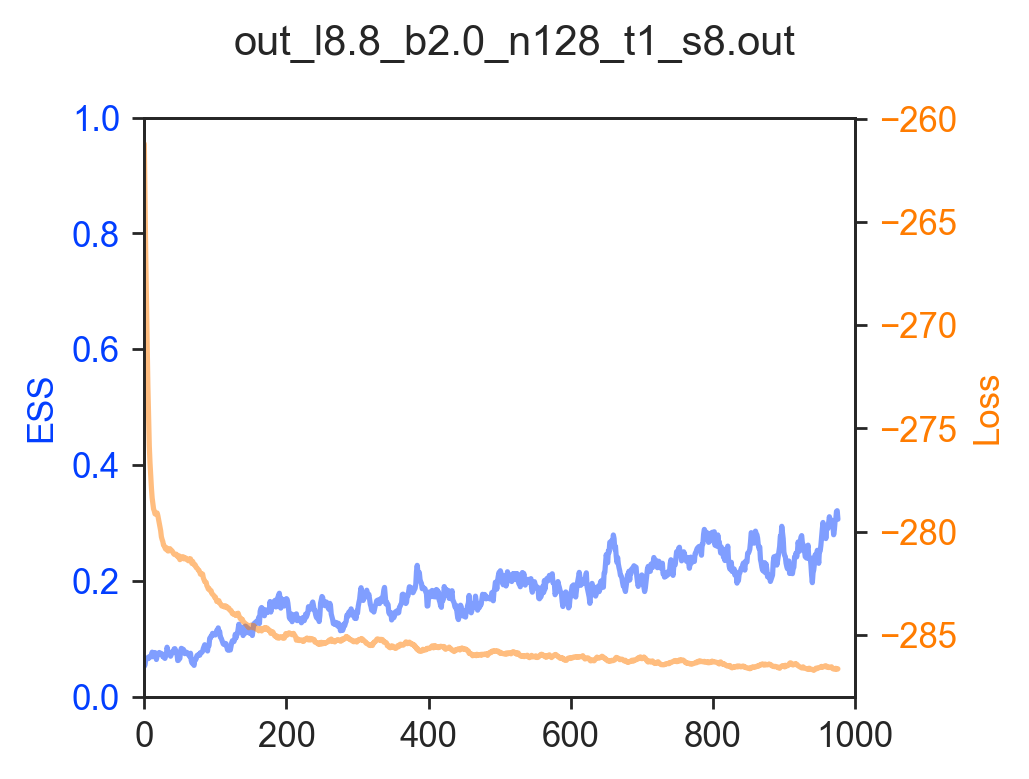

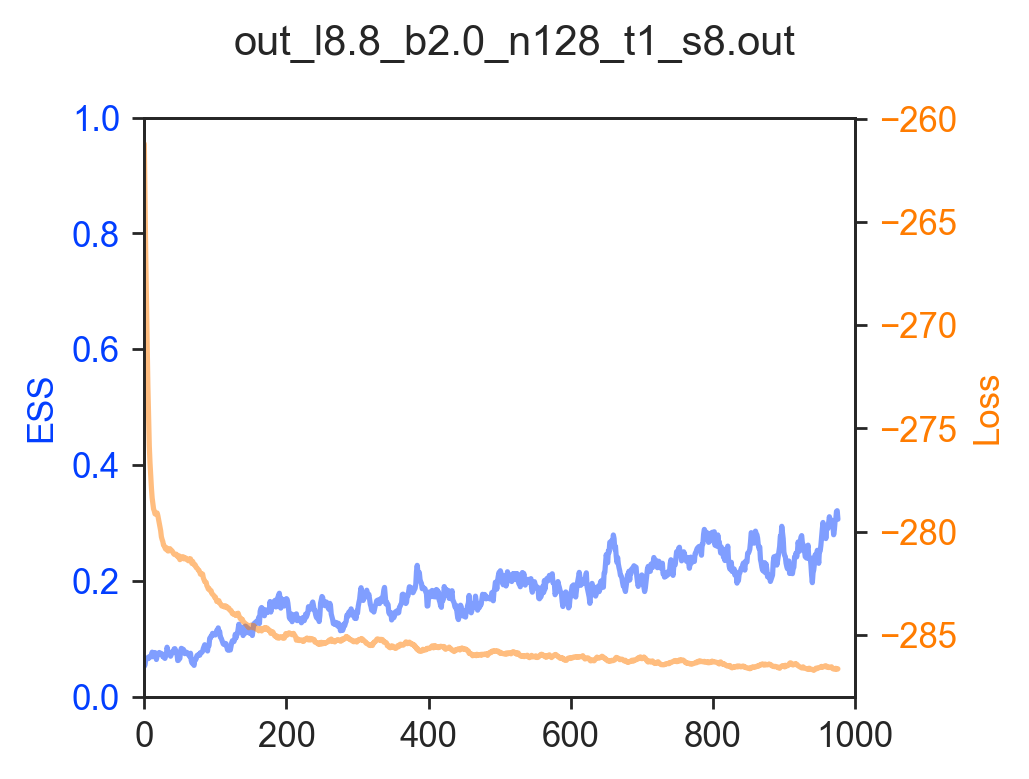

In [20]:
train_params = {
    'n_era': 10,
    'n_epoch': 100,
    'n_layers': 24,
    'n_s_nets': 2,
    'hidden_sizes': [8, 8],
    'kernel_size': 3,
    'batch_size': 32,
    'print_freq': 5,
    'plot_freq': 10,
}

pre_flow_model, flow_act = flow_train(param, **train_params)

In [21]:
u1_ens = flow_eval(pre_flow_model,flow_act)
pre_flow = pre_flow_model['layers']

In [22]:
u1_ens = flow_eval(pre_flow_model, flow_act)
pre_flow = pre_flow_model['layers']

In [23]:
train_force = False
flow_model = None
if train_force:
    flow_model, flow_act = flow_train(param, with_force=True, pre_model=pre_flow_model)
else:
    flow_model = pre_flow_model
    
u1_ens = flow_eval(flow_model,flow_act)
flow = flow_model['layers']
# flow.eval()

In [24]:
def test_force(x = None):
    model = flow_model
    layers, prior = model['layers'], model['prior']
    if x == None:
        pre_model = pre_flow_model
        pre_layers, pre_prior = pre_model['layers'], pre_model['prior']
        pre_xi = pre_prior.sample_n(1)
        x = qed.ft_flow(pre_layers, pre_xi)
    xi = qed.ft_flow_inv(layers, x)
    f = qed.ft_force(param, layers, xi)
    f_s = torch.linalg.norm(f)
    put(f_s)

In [27]:
test_force()
#test_force(torch.reshape(field, (1,)+field.shape))
test_force(field[None, :])

In [35]:
fields = run(param, field)

In [39]:
fields_arr = torch.stack(tuple(fields.values()), dim=0)

In [47]:
field_run = torch.stack(tuple(fields.values()), dim=0)
flows = flow

put(f'plaq(field_run[0]) {qed.action(param, field_run[0][None, :]) / (-param.beta*param.volume)}')
# field.requires_grad_(True)
x = field_run[0][None, :]
logJ = 0.0
for layer in reversed(flows):
    x, lJ = layer.reverse(x)
    logJ += lJ

# x is the prior distribution now
    
x.requires_grad_(True)
    
y = x
logJy = 0.0
for layer in flows:
    y, lJ = layer.forward(y)
    logJy += lJ
    
s = qed.action(param, y[0][None, :]) - logJy

put(f'logJ: {qed.grab(logJ)}')
put(f'logJy: {qed.grab(logJy)}')
#print(logJ,logJy)


# print("eff_action", s + 136.3786)

put(f'original_action: {qed.action(param, y[0][None, :]) + 91}')
#print("original_action", qed.action(param, y[0][None, :]) + 91)

put(f'eff_action: {s + 56}')
#print("eff_action", {s + 56)

s.backward()

f = x.grad

x.requires_grad_(False)

put(f'plaq(x) {qed.action(param, x[0][None, :]) / (-param.beta*param.volume)}  logJ {qed.grab(logJ)}  force.norm {torch.linalg.norm(f)}')

put(f'plaq(y) {qed.action(param, y[0][None, :]) / (-param.beta*param.volume)}')

put(f'plaq(x) {qed.action(param, field_run[0][None, :]) / (-param.beta*param.volume)}  force.norm {torch.linalg.norm(qed.force(param, field_run[0][None, :]))}')


tensor([[[[3.7227, 6.1491, 5.3310, 5.0758, 1.2846, 3.0765, 4.9623, 1.2385],
          [1.3566, 2.0461, 0.6424, 6.2791, 2.4805, 2.0825, 5.6617, 3.1920],
          [5.3712, 5.7387, 2.4606, 6.2530, 4.4997, 1.2169, 1.3175, 2.8798],
          [3.3933, 1.8546, 0.3204, 3.5644, 3.5259, 2.5246, 1.4845, 2.5569],
          [5.4980, 5.2834, 4.2248, 0.6113, 3.4417, 4.3464, 3.1703, 4.4462],
          [2.5990, 2.5121, 4.4838, 5.4744, 6.2348, 3.4581, 3.6669, 4.2683],
          [1.9971, 4.1673, 5.2147, 4.7044, 4.9836, 1.2862, 1.8134, 0.8509],
          [1.1162, 1.3797, 2.8715, 1.5432, 4.3656, 0.7638, 1.4795, 1.1322]],

         [[2.2294, 4.8620, 6.2448, 3.3178, 0.6683, 3.4256, 2.2454, 3.9473],
          [4.2232, 0.4647, 4.1661, 2.2279, 5.9449, 2.4266, 5.9247, 2.4120],
          [1.0031, 5.8889, 3.5856, 3.2527, 1.3353, 0.9205, 0.4262, 1.3099],
          [3.5102, 0.4529, 3.8771, 1.9588, 0.7301, 1.4881, 1.8434, 4.7956],
          [0.6935, 1.7662, 1.8002, 2.8657, 5.0363, 3.2451, 2.8995, 4.5583],
          

tensor([[[[3.7227, 6.1491, 5.3310, 5.0758, 1.2846, 3.0765, 4.9623, 1.2385],
          [1.3566, 2.0461, 0.6424, 6.2791, 2.4805, 2.0825, 5.6617, 3.1920],
          [5.3712, 5.7387, 2.4606, 6.2530, 4.4997, 1.2169, 1.3175, 2.8798],
          [3.3933, 1.8546, 0.3204, 3.5644, 3.5259, 2.5246, 1.4845, 2.5569],
          [5.4980, 5.2834, 4.2248, 0.6113, 3.4417, 4.3464, 3.1703, 4.4462],
          [2.5990, 2.5121, 4.4838, 5.4744, 6.2348, 3.4581, 3.6669, 4.2683],
          [1.9971, 4.1673, 5.2147, 4.7044, 4.9836, 1.2862, 1.8134, 0.8509],
          [1.1162, 1.3797, 2.8715, 1.5432, 4.3656, 0.7638, 1.4795, 1.1322]],

         [[2.2294, 4.8620, 6.2448, 3.3178, 0.6683, 3.4256, 2.2454, 3.9473],
          [4.2232, 0.4647, 4.1661, 2.2279, 5.9449, 2.4266, 5.9247, 2.4120],
          [1.0031, 5.8889, 3.5856, 3.2527, 1.3353, 0.9205, 0.4262, 1.3099],
          [3.5102, 0.4529, 3.8771, 1.9588, 0.7301, 1.4881, 1.8434, 4.7956],
          [0.6935, 1.7662, 1.8002, 2.8657, 5.0363, 3.2451, 2.8995, 4.5583],
          

In [49]:
put(x.shape)
x = qed.ft_flow_inv(flow, field_run)
# x = field_run
#for layer in reversed(flows):
#    x, lJ = layer.reverse(x)
ff = qed.ft_force(param, flow, x)
put(torch.linalg.norm(ff))
fff = qed.ft_force(param, flow, x)
put(torch.linalg.norm(fff))

In [52]:
x = qed.ft_flow_inv(flow, field_run)
put(qed.grab(qed.ft_action(param, flow, x)))

In [53]:
def flattern(l):
    return [x for y in l for x in y]

def average(l):
    return sum(l) / len(l)

def sub_avg(l):
    avg = average(l)
    return np.array([x - avg for x in l])

In [94]:
ft_hmc_info_list = []
def ft_leapfrog(param, flow, x, p):
    mom_norm = torch.sum(p*p)
    info_list = []
    dt = param.dt
    x_ = x + 0.5*dt*p
    f = qed.ft_force(param, flow, x_)
    p_ = p + (-dt)*f
    info = np.array((float(torch.linalg.norm(f)),
                     float(qed.ft_action(param, flow, x_).detach()),
                     float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
    info_list.append(info)
    for i in range(param.nstep-1):
        x_ = x_ + dt*p_
        f = qed.ft_force(param, flow, x_)
        info = np.array((float(torch.linalg.norm(f)),
                        float(qed.ft_action(param, flow, x_).detach()),
                        float(torch.sum(p*p_)/np.sqrt(mom_norm*torch.sum(p_*p_)))))
        info_list.append(info)
        p_ = p_ + (-dt)*f
    x_ = x_ + 0.5*dt*p_
    info_ = [
        np.sqrt(average([l[0] ** 2 for l in info_list])),
        (info_list[0][1], info_list[-1][1]),
        info_list[-1][2]
    ]
    put(', '.join([f'{i}' for i in info_]))
        
    ft_hmc_info_list.append(info_list)
    return (x_, p_)

def ft_hmc(param, flow, field):
    x = qed.ft_flow_inv(flow, field)
    p = torch.randn_like(x)
    act0 = qed.ft_action(param, flow, x).detach() + 0.5*torch.sum(p*p)
    x_, p_ = ft_leapfrog(param, flow, x, p)
    xr = qed.regularize(x_)
    act = qed.ft_action(param, flow, xr).detach() + 0.5*torch.sum(p_*p_)
    prob = torch.rand([], dtype=torch.float64)
    dH = act - act0
    exp_mdH = torch.exp(-dH)
    acc = prob < exp_mdH
    # ADJUST ME
    newx = xr if acc else x
    # newx = xr
    newfield = qed.ft_flow(flow, newx)
    return (float(dH), float(exp_mdH), acc, newfield)

In [107]:
def ft_run(param, flow, field = None):
    if field == None:
        field = param.initializer()
    ft_hmc_info_list = []
    with open(param.uniquestr(), "w") as O:
        params = param.summary()
        O.write(params)
        put(params)
        plaq = qed.action(param, torch.squeeze(field)) / (-param.beta*param.volume)
        topo = qed.topo_charge(torch.squeeze(field)[None, :])
        #plaq, topo = (qed.action(param, field[None, :]) / (-param.beta*param.volume), qed.topo_charge(field[None, :]))
        status = f"Initial configuration:  plaq: {plaq}  topo: {topo}\n"
        O.write(status)
        put(status)
        ts = []
        for n in range(param.nrun):
            t = -timer()
            for i in range(param.ntraj):
                #field_run = torch.reshape(field,(1,)+field.shape)
                
                dH, exp_mdH, acc, field = ft_hmc(param, flow, torch.squeeze(field)[None, :])
                plaq = qed.action(param, field) / (-param.beta*param.volume)
                topo = qed.topo_charge(torch.squeeze(field)[None, :])
                ifacc = "ACCEPT" if acc else "REJECT"
                status = {
                    'traj': f'{n * param.ntraj+i+1:4}',
                    'accept': f'{qed.grab(acc)[0]}',
                    'dH': f'{dH:< 12.8}',
                    'expdH': f'{exp_mdH:< 12.8}',
                    'plaq': f'{plaq:< 12.8}',
                    'topo': f'{qed.grab(topo)[0]:< 3.3}',
                }
                outstr = ', '.join(
                    '='.join((k, v)) for k, v in status.items()
                )
                O.write(outstr + '\n')
                if (i + 1) % (param.ntraj // param.nprint) == 0:
                    put(outstr)
            t += timer()
            ts.append(t)
        print("Run times: ", ts)
        print("Per trajectory: ", [t/param.ntraj for t in ts])
    return field

In [100]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow_model['layers'], field)

Run times:  [32.68285684000011, 38.06345353699999, 34.63871367799993, 32.7064832179999]
Per trajectory:  [8.170714210000028, 9.515863384249997, 8.659678419499983, 8.176620804499976]


In [108]:
param = Param(
    beta = 2.0,
    lat = (8, 8),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

# field = ft_run(param, pre_flow)
field = ft_run(param, pre_flow_model['layers'], field[None, :])

Run times:  [32.41215487399995, 32.01637827900004, 37.18454874400004, 39.78543267100031]
Per trajectory:  [8.103038718499988, 8.00409456975001, 9.29613718600001, 9.946358167750077]


In [109]:
action_list = np.array([l[1] for l in flattern(ft_hmc_info_list)])
action_list = sub_avg(action_list)
put(np.sqrt(average(action_list**2)))

In [110]:
force_list = np.array([l[0] for l in flattern(ft_hmc_info_list)])
put(np.sqrt(average(force_list**2)))

In [112]:
put(np.array(force_list[0:300]))

In [113]:
param_new = Param(
    beta = 2.0,
    lat = (12, 12),
    tau = 0.5, # 0.3
    nstep = 64, # 3
    # ADJUST ME
    ntraj = 4, # 2**16 # 2**10 # 2**15
    nprint = 4,
    #
    seed = 1331)

field_new = run(param_new)

In [114]:
def get_nets(layers):
    nets = []
    for l in layers:
        nets.append(l.plaq_coupling.net)
    return nets

In [118]:
from utils.layers import NCPPlaqCouplingLayer, GaugeEquivCouplingLayer
    
def make_u1_equiv_layers_net(*, lattice_shape, nets):
    n_layers = len(nets)
    layers = []
    for i in range(n_layers):
        # periodically loop through all arrangements of maskings
        mu = i % 2
        off = (i//2) % 4
        net = nets[i]
        plaq_coupling = NCPPlaqCouplingLayer(
            net, mask_shape=lattice_shape, mask_mu=mu, mask_off=off)
        link_coupling = GaugeEquivCouplingLayer(
            lattice_shape=lattice_shape, mask_mu=mu, mask_off=off, 
            plaq_coupling=plaq_coupling)
        layers.append(link_coupling)
    return torch.nn.ModuleList(layers)

In [119]:
len(get_nets(flow))

24

In [120]:
flow_new = make_u1_equiv_layers_net(lattice_shape = param_new.lat, nets = get_nets(flow))

In [121]:
field_new = ft_run(param_new, flow_new)

Run times:  [33.15082019600004, 41.633759468000335, 35.45425841300039, 29.469482321000214]
Per trajectory:  [8.28770504900001, 10.408439867000084, 8.863564603250097, 7.3673705802500535]


In [122]:
field_new = ft_run(param_new, flow_new, field_new)

Run times:  [42.63277566600027, 35.20892139500029, 30.217469374999837, 30.386221675999877]
Per trajectory:  [10.658193916500068, 8.802230348750072, 7.554367343749959, 7.596555418999969]


In [125]:
put(f'action: {qed.action(param, field)}')
put(f'action (new): {qed.action(param_new, field_new)}')